In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

import json
import datetime

import warnings
warnings.filterwarnings('ignore')

### Import and Clean Data

In [2]:
def parse_json(data):
    """ function to parse json data """
    session_id = []
    timestamp = []
    cities = []
    user_id = []
    joining_date = []
    country = []
    
    # parse each item
    for item in data:
        session_id.append(item['session_id'][0])
        timestamp.append(datetime.datetime.utcfromtimestamp(item['unix_timestamp'][0]))
        cities.append(item['cities'][0])
        user_id.append(item['user'][0][0]['user_id'])
        joining_date.append(item['user'][0][0]['joining_date'])
        country.append(item['user'][0][0]['country'])
    
    # create DataFrame
    maps = {'session_id': session_id, 'timestamp': timestamp, 'cities': cities, 
            'user_id': user_id, 'joining_date': joining_date, 'country': country}
    columns=['session_id', 'timestamp', 'cities', 'user_id', 'joining_date', 'country']
    
    return pd.DataFrame(maps, columns=columns)

In [3]:
with open('C:/Sophia/School!!!/2023 Spring 1/DS take home/13.user_activity/city_searches.json', 'r') as f:
    json_data = json.load(f)

data = parse_json(json_data)
data['joining_date'] = pd.to_datetime(data['joining_date'])
data.head()

,session_id,timestamp,cities,user_id,joining_date,country
0,D258NVMV202LS,2015-09-19 05:29:12,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,2015-05-20 08:22:17,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,2015-07-16 12:21:51,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,2015-05-21 13:45:08,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,2015-09-29 19:50:26,"Toronto ON, Houston TX",10493,2015-03-31,US


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   session_id    20022 non-null  object        
 1   timestamp     20022 non-null  datetime64[ns]
 2   cities        20022 non-null  object        
 3   user_id       20022 non-null  int64         
 4   joining_date  20022 non-null  datetime64[ns]
 5   country       20022 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 938.7+ KB


### Q1: There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?

In [5]:
data['country'].value_counts().reset_index().rename(columns={'index': 'country', 'country': 'count'})

,country,count
0,US,3772
1,UK,3754
2,DE,3741
3,,2769
4,FR,2341
5,IT,1843
6,ES,1802


Given the current dataset, since there are little information about the dataset, one information that could be used to guess the country is the search time. Since people in different countries will search in similar local time, we can use this information to guess the country.

In [6]:
data['hour'] = data['timestamp'].apply(lambda x: x.hour)

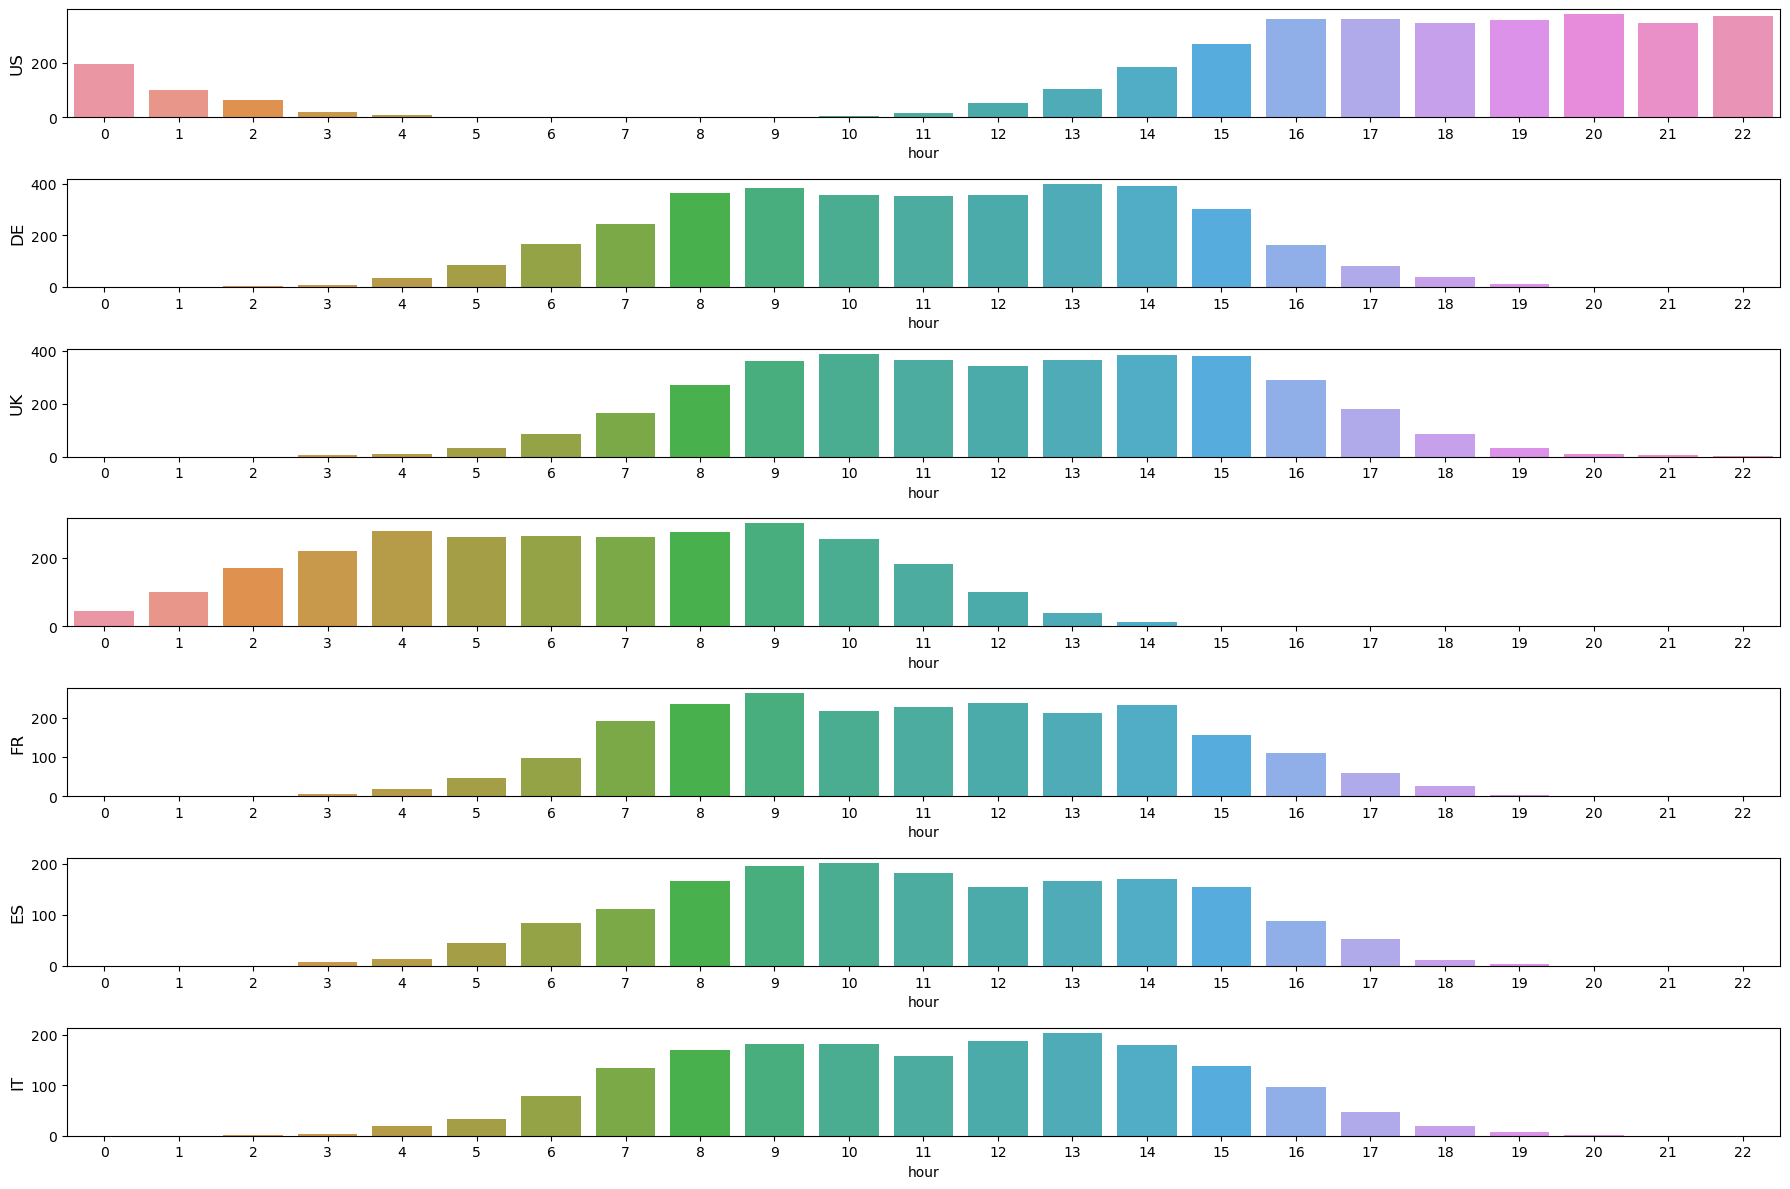

In [7]:
# visualization
country_list = ['US', 'DE', 'UK', '', 'FR', 'ES', 'IT']
order = list(range(0, 23))
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(18, 12))
for i in range(len(country_list)):
    sns.countplot(x='hour', data=data[data['country'] == country_list[i]], ax=ax[i], order=order)
    ax[i].set_ylabel(country_list[i], fontsize=12)
plt.tight_layout()
plt.show()

Based on above figure, we can see that, for the unknown country, their peak search time has around 12 hours difference with United States, and around 5 hours difference with Europe. Based on the geographic locations of each country, it seems that this missing country is in Asia. Possible countries include China, Japan or South Korean.

### Q2: For each city, find the most likely city to be also searched for within the same session.

For this question, we will create a matrix that calculate the city-city similarity.

In [8]:
# find unique cities
city_pair = data['cities'].apply(lambda x: x.split(', '))

index = 0
maps = {}
city_list = []
for item in city_pair:
    for city in item:
        if city not in maps:
            maps[city] = index
            index += 1
            city_list.append(city)
            
print('Unique cities:\t', len(city_list))

Unique cities:	 87


In [9]:
# calculate matrix similarity
pair_matrix = np.zeros((87, 87))

for item in city_pair:
    if len(item) == 1:
        continue
    for i in range(len(item) - 1):
        index1 = maps[item[i]]
        for j in range(i + 1, len(item)):
            index2 = maps[item[j]]
            pair_matrix[index1, index2] += 1
            pair_matrix[index2, index1] += 1

In [10]:
# create dataframe
df_similarity = pd.DataFrame(pair_matrix, index=city_list, columns=city_list)
df_similarity.head()

,San Jose CA,Montreal QC,New York NY,Quebec QC,Chicago IL,Toronto ON,Houston TX,Los Angeles CA,San Diego CA,Santa Ana CA,...,Norfolk VA,Atlanta GA,Charlotte NC,Raleigh NC,Lincoln NE,Omaha NE,Kansas City MO,Birmingham AL,Minneapolis MN,Memphis TN
San Jose CA,0.0,17.0,40.0,0.0,12.0,25.0,7.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Montreal QC,17.0,0.0,339.0,111.0,101.0,254.0,77.0,154.0,18.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
New York NY,40.0,339.0,0.0,7.0,260.0,427.0,172.0,318.0,62.0,0.0,...,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quebec QC,0.0,111.0,7.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chicago IL,12.0,101.0,260.0,0.0,0.0,145.0,74.0,116.0,20.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,12.0,0.0


In [11]:
# get result
result = df_similarity.apply(np.argmax, axis=0).reset_index()
result = result.rename(columns={'index': 'city', 0: 'most similar'})
result

,city,most similar
0,San Jose CA,61
1,Montreal QC,2
2,New York NY,17
3,Quebec QC,1
4,Chicago IL,2
...,...,...
82,Omaha NE,4
83,Kansas City MO,44
84,Birmingham AL,31
85,Minneapolis MN,4


In [12]:
df1 = pd.DataFrame(df_similarity.reset_index()['index'])
df1 = df1.rename(columns={'index': 'city'})
df1

,city
0,San Jose CA
1,Montreal QC
2,New York NY
3,Quebec QC
4,Chicago IL
...,...
82,Omaha NE
83,Kansas City MO
84,Birmingham AL
85,Minneapolis MN


In [13]:
df2 = df_similarity.apply(np.argmax)

lst = []
for i in df2:
    lst.append(df_similarity.reset_index()['index'][i])
    
df3 = pd.DataFrame(lst)
df3 = df3.rename(columns={0: 'most similar'})
print(df3)

       most similar
0        Oakland CA
1       New York NY
2    Jersey City NJ
3       Montreal QC
4       New York NY
..              ...
82       Chicago IL
83        Dallas TX
84  Jacksonville FL
85       Chicago IL
86      Columbus OH

[87 rows x 1 columns]


In [14]:
pd.merge(df1, df3, left_index=True, right_index=True)

,city,most similar
0,San Jose CA,Oakland CA
1,Montreal QC,New York NY
2,New York NY,Jersey City NJ
3,Quebec QC,Montreal QC
4,Chicago IL,New York NY
...,...,...
82,Omaha NE,Chicago IL
83,Kansas City MO,Dallas TX
84,Birmingham AL,Jacksonville FL
85,Minneapolis MN,Chicago IL


### Q3: Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

For this question, one way is to actually calculate the geographic distance for actual searched cities. However, this solution is not very practical for this small project. Another choice is to calculate the distance based on the city-city similarity in Question 2.

In [15]:
data.head(10)

,session_id,timestamp,cities,user_id,joining_date,country,hour
0,D258NVMV202LS,2015-09-19 05:29:12,"San Jose CA, Montreal QC",5749,2015-04-02,FR,5
1,TDG10UKG7I4LR,2015-05-20 08:22:17,New York NY,10716,2015-03-30,DE,8
2,OH4ZDIGN9BLQS,2015-07-16 12:21:51,"Montreal QC, Quebec QC",2941,2015-03-16,,12
3,CWHIAYKQ7RA28,2015-05-21 13:45:08,Chicago IL,2164,2015-03-27,FR,13
4,GI8GZJAWAC80P,2015-09-29 19:50:26,"Toronto ON, Houston TX",10493,2015-03-31,US,19
5,NRMA4TM621WRD,2015-03-20 08:24:38,New York NY,326,2015-03-14,IT,8
6,ZD0XZK1U43LK6,2015-09-03 08:46:11,Los Angeles CA,4417,2015-04-02,IT,8
7,5FWYK13BT295Y,2015-08-18 09:22:32,"San Diego CA, Santa Ana CA",8056,2015-03-19,FR,9
8,FHDJFT27R46XS,2015-05-09 08:45:58,New York NY,7146,2015-03-21,,8
9,PWERIG07P4511,2015-09-16 14:46:44,"Toronto ON, Saint Catharines-Niagara ON",9705,2015-03-07,DE,14


In [16]:
def search_distance(cities):
    cities = cities.split(', ')
    
    if len(cities) == 1:
        return 0  # user only search one city, distance 0
    
    distance = 0
    for i in range(len(cities) - 1):
        city1 = cities[i]
        for j in range(i + 1, len(cities)):
            city2 = cities[j]
            distance += df_similarity.loc[city1, city2]
            
    return distance / len(cities)

# calculate distance
data['distance'] = data['cities'].apply(search_distance)

In [17]:
data.head(10)

,session_id,timestamp,cities,user_id,joining_date,country,hour,distance
0,D258NVMV202LS,2015-09-19 05:29:12,"San Jose CA, Montreal QC",5749,2015-04-02,FR,5,8.5
1,TDG10UKG7I4LR,2015-05-20 08:22:17,New York NY,10716,2015-03-30,DE,8,0.0
2,OH4ZDIGN9BLQS,2015-07-16 12:21:51,"Montreal QC, Quebec QC",2941,2015-03-16,,12,55.5
3,CWHIAYKQ7RA28,2015-05-21 13:45:08,Chicago IL,2164,2015-03-27,FR,13,0.0
4,GI8GZJAWAC80P,2015-09-29 19:50:26,"Toronto ON, Houston TX",10493,2015-03-31,US,19,57.5
5,NRMA4TM621WRD,2015-03-20 08:24:38,New York NY,326,2015-03-14,IT,8,0.0
6,ZD0XZK1U43LK6,2015-09-03 08:46:11,Los Angeles CA,4417,2015-04-02,IT,8,0.0
7,5FWYK13BT295Y,2015-08-18 09:22:32,"San Diego CA, Santa Ana CA",8056,2015-03-19,FR,9,65.5
8,FHDJFT27R46XS,2015-05-09 08:45:58,New York NY,7146,2015-03-21,,8,0.0
9,PWERIG07P4511,2015-09-16 14:46:44,"Toronto ON, Saint Catharines-Niagara ON",9705,2015-03-07,DE,14,139.5


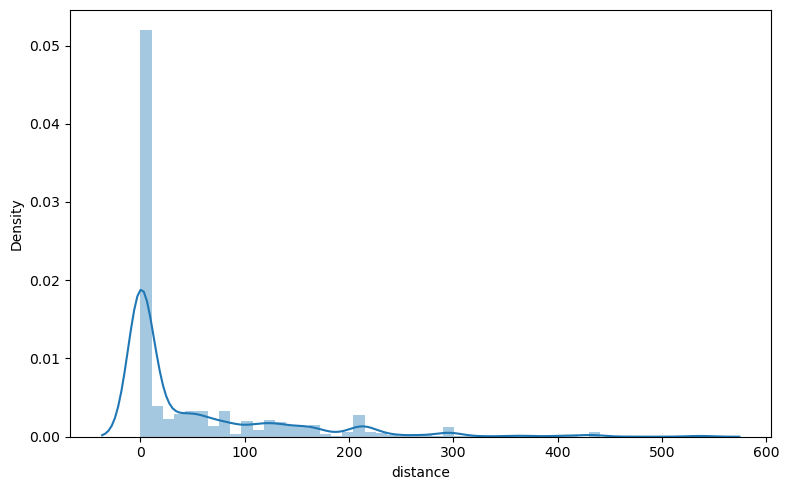

In [18]:
# visualization
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(data['distance'], ax=ax, bins=50)
plt.tight_layout()
plt.show()

It seems that we can set some threshold to cut the search distance such that any search that is above the threshold are assumed to be the search with low intent.